# Image Access

In this notebook, we show how to search for and retrieve images from VO services using the Registry and the __[Simple Image Access](http://www.ivoa.net/documents/SIA/)__ (SIA) protocol.

- [Image Access](#image-access)
  - [1. Finding SIA resources from the Registry](#1-finding-sia-resources-from-the-registry)
  - [2. Using SIA to retrieve an image](#2-using-sia-to-retrieve-an-image)
  - [3. Viewing the resulting image](#3-viewing-the-resulting-image)
    - [JPG images](#jpg-images)
    - [Fits files](#fits-files)
  - [4. Example of data available through multiple services](#4-example-of-data-available-through-multiple-services)
    - [Using HEASARC](#using-heasarc)
    - [Using SDSS SkyServer](#using-sdss-skyserver)

**\*Note:**  for all of these notebooks, the results depend on real-time queries.  Sometimes there are problems, either because a given service has changed, is undergoing maintenance, or the internet connectivity is having problems, etc.  Always retry a couple of times, come back later and try again, and only then send us the problem report to investigate.

In [1]:
import warnings

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pyvo as vo

from astropy.io import fits
import astropy.coordinates as coord
# For downloading files
from astropy.utils.data import download_file

from IPython.display import Image as ipImage, display

# There are a number of relatively unimportant warnings that show up, so for now, suppress them:
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")

## 1. Finding SIA resources from the Registry

First, how do we find out what  services are available?  These are listed in a registry at STScI (__[see here](http://www.ivoa.net/documents/RegTAP/)__).  Our Registry function gives a simple interface for how to search for services.

Let's search for services providing images in the ultraviolet bands:

In [2]:
uv_services = vo.regsearch(servicetype='sia',waveband='uv')
uv_services.to_table()['ivoid','short_name','res_title']

ivoid,short_name,res_title
object,object,object
ivo://archive.stsci.edu/sia/galex,GALEX,Galaxy Evolution Explorer (GALEX)
ivo://archive.stsci.edu/siap/hla,HLA,Hubble Legacy Archive
ivo://irsa.ipac/mast/scrapbook,MAST-Scrapbook,The MAST Image Scrapbook
ivo://mast.stsci/acsggct,HST.ACSGGCT,ACS Galactic Globular Cluster Survey (ACSGGCT)
ivo://mast.stsci/angrrr,HST.ANGRRR,"Archive of Nearby Galaxies: Reduce, Reuse, Recycle (ANGRRR)"
ivo://mast.stsci/candels,CANDELS,Cosmic Assembly Near-IR Deep Extragalactic Legacy Survey (CANDELS)
ivo://mast.stsci/clash,HST.CLASH,Cluster Lensing And Supernova survey with Hubble (CLASH)
ivo://mast.stsci/hippies,HST.HIPPIES,Hubble Infrared Pure Parallel Imaging Extragalactic Survey (HIPPIES)
ivo://mast.stsci/phat,PHAT,Panchromatic Hubble Andromeda Treasury (PHAT)


This returns an astropy table containing information about the services available.  We can then specify the service we want by using the corresponding row.  We'll repeat the search with additional qualifiers to isolate the row we want (note that in the keyword search the "%" character can be used as a wild card):

In [3]:
uvot_services = vo.regsearch(servicetype='sia',waveband='uv',keywords=['swift'])
uvot_services.to_table()['ivoid','short_name','res_title']

ivoid,short_name,res_title
object,object,object
ivo://nasa.heasarc/skyview/swiftuvot,SWIFTUVOT,Swift UVOT Combined V Intensity Images


This shows us that the data we are interested in comes from the HEASARC's SkyView service, but the point of these VO tools is that you don't need to know that ahead of time or indeed to care where it comes from.

## 2. Using SIA to retrieve an image

Now we look for images of our favorite source.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you can specify the central position and the size (degrees as one or two floats for the RA, DEC directions).  It is up to the service to determine how to provide this. Optionally, you can limit it to the format you want, e.g., "image/fits" or "image/png" etc.

What is returned to you is not the image itself but a list of images available and how to access them.  This is easiest shown by example:

In [4]:
coords = coord.SkyCoord.from_name("m51")

im_table = uvot_services[0].search(pos=coords,size=0.2,format='image/jpeg')
im_table.to_table()

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
swiftuvotvint,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925032792&nofits=1&quicklook=jpeg&return=jpeg,1
swiftuvotbint,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925033094&nofits=1&quicklook=jpeg&return=jpeg,2
swiftuvotuint,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925034224&nofits=1&quicklook=jpeg&return=jpeg,3
swiftuvotuvw1int,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925034739&nofits=1&quicklook=jpeg&return=jpeg,4
swiftuvotuvw2int,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotuvw2int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925035263&nofits=1&quicklook=jpeg&return=jpeg,5
swiftuvotuvm2int,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotuvm2int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925035812&nofits=1&quicklook=jpeg&return=jpeg,6


Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG.

Note that different services will return different column names, but all will have a column giving the URL to access the image.  Though it has different column names in different services, it can always be accessed through the `getdataurl` function.

In [5]:
url = im_table[0].getdataurl()
print(url)

https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925032792&nofits=1&quicklook=jpeg&return=jpeg


## 3. Viewing the resulting image

### JPG images

Since we have asked for JPEG images, we can display an image in python easily by using its URL. Each row of the result has a getdataurl() method, and you can then hand the URL to an image displayer such as IPython.display:

In [6]:
img = ipImage(url=im_table[0].getdataurl())
display(img)

### Fits files

Or download the FITS image and display it with imshow, or aplpy.

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

In [7]:
#  Do the search again asking for FITS
im_table = uvot_services[0].search(pos=coords,size=0.2,format='image/fits')

#  Hand the url of the first result to fits.open()
hdu_list = fits.open(im_table[0].getdataurl())
hdu_list.info()

Filename: /home/runner/.astropy/cache/download/url/41856ae32f4e530158f97f295cfa3288/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     111   (300, 300)   float32   


#### Using imshow

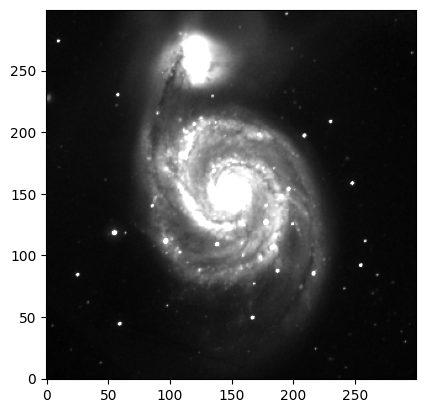

In [8]:
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.1)

## 4. Example of data available through multiple services

Suppose we want Sloan DSS data.  A generic query finds us a number of possibilities (note that this doesn't work for keywords=['sdss'];  be flexible and try several search terms):

In [9]:
services = vo.regsearch(servicetype='sia', keywords=['sloan'], waveband='optical')
services.to_table()[np.where(np.isin(services.to_table()['short_name'], 'SDSSDR7'))]['ivoid', 'short_name']

ivoid,short_name
object,object
ivo://nasa.heasarc/skyview/sdssdr7,SDSSDR7
ivo://sdss.jhu/services/siapdr7-images,SDSSDR7


So one of these is served by SDSS's SkyServer and the other by HEASARC's SkyView.

### Using HEASARC

In [10]:
heasarc_dr7_service = [s for s in services if 'SDSSDR7' in s.short_name and 'heasarc' in s.ivoid][0]

sdss_table_heasarc = heasarc_dr7_service.search(pos=coords,size=0.2,format='image/fits')
sdss_table_heasarc.to_table()

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
sdssdr7g,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7g&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925043355&return=FITS,1
sdssdr7i,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7i&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925043815&return=FITS,2
sdssdr7u,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7u&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925044370&return=FITS,3
sdssdr7r,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7r&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925044873&return=FITS,4
sdssdr7z,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7z&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1730925045415&return=FITS,5


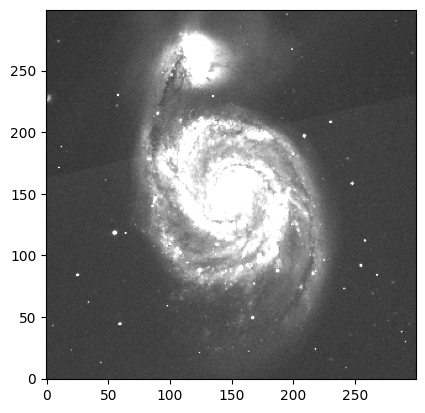

In [11]:
## If you only run this once, you can do it in memory in one line:
##  This fetches the FITS as an astropy.io.fits object in memory
# hdu_list = sdss_table_heasarc[0].getdataobj()
## But if you might run this notebook repeatedly with limited bandwidth,
##  download it once and cache it.

#  Get the filter g version
file_name=download_file(sdss_table_heasarc[0].getdataurl(), cache=True, timeout=600)
hdu_list = fits.open(file_name)

plt.imshow(hdu_list[0].data, cmap='gray', origin='lower', vmax=1200, vmin=1010)

### Using SDSS SkyServer

In [12]:
jhu_dr7_service = [s for s in services if 'SDSSDR7' in s.short_name and 'jhu' in s.ivoid][0]

# Note: jhu_dr7_service access url has hard-wired "format=image/fits".
# If you specify anythign else, it errors. If you specify nothing,
# then the search() method puts "format=all", which errors. So specify "format=None" for now.
sdss_table_jhu=jhu_dr7_service.search(pos=coords,size=0.2, format=None)
sdss_table_jhu.to_table().show_in_notebook(display_length = 5)

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,Title,width,height,size,RA,DEC,scale,format,url,equinox,naxes,naxis,crtype,crpix,crval,cdval
0,Sloan Digital Sky Survey - Filter u,2048,1489,3049472.0,202.439715840115,47.1222952774076,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-u6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.439715840115 47.1222952774076],[3.57829352076884e-05 0.000157654334590212 0.000107291403325821\n -2.42761847386219e-05]
1,Sloan Digital Sky Survey - Filter g,2048,1489,3049472.0,202.438763451233,47.1224982411069,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-g6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.438763451233 47.1224982411069],[3.57455198349534e-05 0.000157658871914506 0.000107248674325512\n -2.4298297148212e-05]
2,Sloan Digital Sky Survey - Filter r,2048,1489,3049472.0,202.440760551524,47.1223224530134,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-r6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.440760551524 47.1223224530134],[3.57284422970295e-05 0.000157658504949188 0.000107285884319316\n -2.43020165047957e-05]
3,Sloan Digital Sky Survey - Filter i,2048,1489,3049472.0,202.440280828514,47.1221470640024,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-i6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.440280828514 47.1221470640024],[3.57634273620044e-05 0.00015761708892598 0.000107330126376146\n -2.43196618936367e-05]
4,Sloan Digital Sky Survey - Filter z,2048,1489,3049472.0,202.439529079822,47.1222577816612,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-z6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.439529079822 47.1222577816612],[3.57150015372814e-05 0.000157643765195985 0.000107288170305585\n -2.43520424844304e-05]
5,Sloan Digital Sky Survey - Filter u,2048,1489,3049472.0,202.471051455651,47.3353076054504,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-u6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.471051455651 47.3353076054504],[3.59720233632108e-05 0.000158234026889022 0.000107269639460545\n -2.43685414700374e-05]
6,Sloan Digital Sky Survey - Filter g,2048,1489,3049472.0,202.470063167219,47.3355466663192,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-g6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.470063167219 47.3355466663192],[3.59432847686782e-05 0.000158250992709564 0.000107232188959642\n -2.43648103577398e-05]
7,Sloan Digital Sky Survey - Filter r,2048,1489,3049472.0,202.472135546076,47.3353955051599,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-r6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.472135546076 47.3353955051599],[3.59415181020478e-05 0.000158248434019201 0.000107267969211639\n -2.43568204128413e-05]
8,Sloan Digital Sky Survey - Filter i,2048,1489,3049472.0,202.471591570338,47.3352202087437,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-i6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.471591570338 47.3352202087437],[3.59688512209066e-05 0.000158230937820391 0.000107320614280034\n -2.43668898148645e-05]
9,Sloan Digital Sky Survey - Filter z,2048,1489,3049472.0,202.470847588819,47.3353207915745,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-z6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.470847588819 47.3353207915745],[3.59150654057983e-05 0.00015824237549979 0.000107275145174036\n -2.43601106879619e-05]


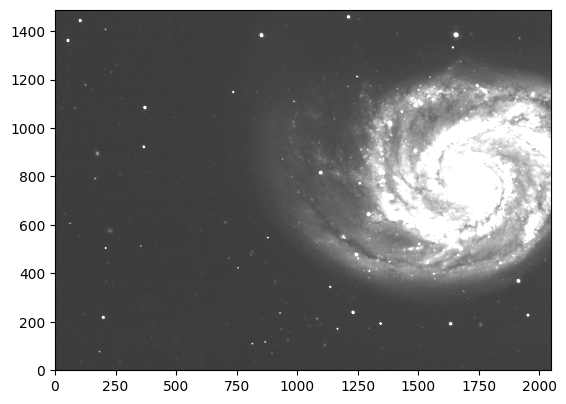

In [13]:
#  Get the filter g version
file_name=download_file(sdss_table_jhu[1].getdataurl(), cache=True, timeout=600)
hdu_list = fits.open(file_name)

plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=1200,vmin=1010)

It turns out that SkyView is just getting images by using the SIAP internally to get the data from the SDSS service.  The point of the VO protocols is that you don't need to know where the data are coming from.  But they can be processed differently.